# Train Real vs Fake Face Classifier

Huấn luyện model phân loại ảnh khuôn mặt thật/giả sử dụng CLIP-ViT-L/14 backbone và linear head.

In [ ]:
import os
# Fix OpenMP conflict error
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Thiết lập seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cấu hình đường dẫn
# NOTE: Khi chuyển lên Kaggle, thay đổi đường dẫn theo cấu trúc thư mục của Kaggle
# Ví dụ: PROJECT_ROOT = Path('/kaggle/working')
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
DATA_ROOT = Path("/kaggle/input/aireal-face-images-50k/processed/sample_1pct")
MODEL_SAVE_PATH = Path("/kaggle/working/")

# Tạo thư mục lưu model
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data root: {DATA_ROOT}")
print(f"Model save path: {MODEL_SAVE_PATH}")

Project root: /kaggle/working
Data root: /kaggle/input/aireal-face-images-50k/processed/sample_1pct
Model save path: /kaggle/working


## 1. Load và khám phá dữ liệu

Thu thập đường dẫn ảnh từ 4 nguồn:
- **celeba**: Ảnh thật (label = 0)
- **fairfacegen**, **person_face_dataset**, **stable_diffusion_faces**: Ảnh giả (label = 1)

In [3]:
# Thu thập đường dẫn ảnh và gán nhãn
ALLOWED_EXT = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

def collect_images(root_path):
    """Thu thập tất cả ảnh từ thư mục"""
    images = []
    for ext in ALLOWED_EXT:
        images.extend(root_path.rglob(f"*{ext}"))
    return images

# Nguồn celeba - ảnh thật (label = 0)
celeba_path = DATA_ROOT / "celeba"
celeba_images = collect_images(celeba_path) if celeba_path.exists() else []

# 3 nguồn ảnh giả (label = 1)
fake_sources = ["fairfacegen", "person_face_dataset", "stable_diffusion_faces"]
fake_images = []
for source in fake_sources:
    source_path = DATA_ROOT / source
    if source_path.exists():
        fake_images.extend(collect_images(source_path))

print(f"Real images (celeba): {len(celeba_images)}")
print(f"Fake images (3 sources): {len(fake_images)}")
print(f"Total images: {len(celeba_images) + len(fake_images)}")

Real images (celeba): 20259
Fake images (3 sources): 37309
Total images: 57568


In [4]:
# Tạo dataset với labels - chia từng nguồn riêng biệt
from sklearn.model_selection import train_test_split

def split_source(images, label, test_size=0.15, val_size=0.15, random_state=SEED):
    """Chia một nguồn ảnh thành train/val/test"""
    if len(images) == 0:
        return [], [], [], [], [], []
    
    paths = [str(img) for img in images]
    labels_list = [label] * len(images)
    
    # Chia train và temp (val + test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        paths, labels_list, test_size=(test_size + val_size), random_state=random_state, shuffle=True
    )
    
    # Chia temp thành val và test
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=(test_size / (test_size + val_size)), 
        random_state=random_state, shuffle=True
    )
    
    return train_paths, train_labels, val_paths, val_labels, test_paths, test_labels

# Chia từng nguồn riêng biệt
print("Chia dữ liệu từng nguồn:")
print("-" * 50)

# Celeba (Real - label 0)
celeba_train_paths, celeba_train_labels, celeba_val_paths, celeba_val_labels, celeba_test_paths, celeba_test_labels = \
    split_source(celeba_images, label=0)
print(f"CelebA (Real): Train={len(celeba_train_paths)}, Val={len(celeba_val_paths)}, Test={len(celeba_test_paths)}")

# 3 nguồn Fake (label 1)
fake_train_paths, fake_train_labels = [], []
fake_val_paths, fake_val_labels = [], []
fake_test_paths, fake_test_labels = [], []

for source in fake_sources:
    source_path = DATA_ROOT / source
    source_images = collect_images(source_path) if source_path.exists() else []
    
    train_p, train_l, val_p, val_l, test_p, test_l = split_source(source_images, label=1)
    
    fake_train_paths.extend(train_p)
    fake_train_labels.extend(train_l)
    fake_val_paths.extend(val_p)
    fake_val_labels.extend(val_l)
    fake_test_paths.extend(test_p)
    fake_test_labels.extend(test_l)
    
    print(f"{source}: Train={len(train_p)}, Val={len(val_p)}, Test={len(test_p)}")

# Gộp tất cả các nguồn lại
train_paths = celeba_train_paths + fake_train_paths
train_labels = celeba_train_labels + fake_train_labels

val_paths = celeba_val_paths + fake_val_paths
val_labels = celeba_val_labels + fake_val_labels

test_paths = celeba_test_paths + fake_test_paths
test_labels = celeba_test_labels + fake_test_labels

# Shuffle mỗi split
def shuffle_data(paths, labels, random_state=SEED):
    combined = list(zip(paths, labels))
    random.Random(random_state).shuffle(combined)
    paths, labels = zip(*combined)
    return list(paths), list(labels)

train_paths, train_labels = shuffle_data(train_paths, train_labels)
val_paths, val_labels = shuffle_data(val_paths, val_labels)
test_paths, test_labels = shuffle_data(test_paths, test_labels)

print("-" * 50)
print(f"\nTổng kết:")
print(f"Train: {len(train_paths)} (Real: {train_labels.count(0)}, Fake: {train_labels.count(1)})")
print(f"Val: {len(val_paths)} (Real: {val_labels.count(0)}, Fake: {val_labels.count(1)})")
print(f"Test: {len(test_paths)} (Real: {test_labels.count(0)}, Fake: {test_labels.count(1)})")
print(f"Total: {len(train_paths) + len(val_paths) + len(test_paths)}")

Chia dữ liệu từng nguồn:
--------------------------------------------------
CelebA (Real): Train=14181, Val=3039, Test=3039
fairfacegen: Train=24786, Val=5311, Test=5312
person_face_dataset: Train=700, Val=150, Test=150
stable_diffusion_faces: Train=630, Val=135, Test=135
--------------------------------------------------

Tổng kết:
Train: 40297 (Real: 14181, Fake: 26116)
Val: 8635 (Real: 3039, Fake: 5596)
Test: 8636 (Real: 3039, Fake: 5597)
Total: 57568


## 2. Xem ảnh mẫu từ mỗi nguồn

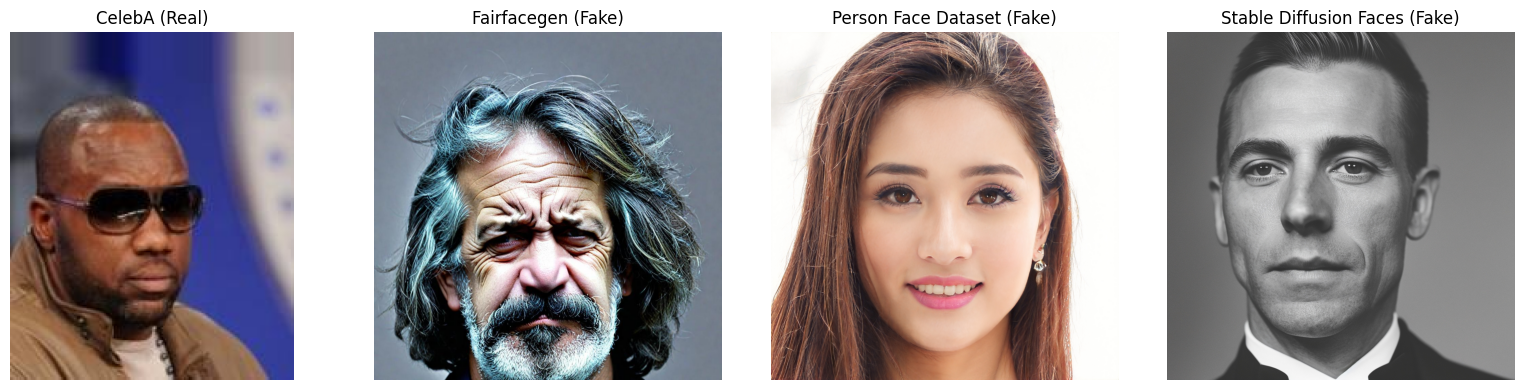

In [5]:
# Hiển thị 1 ảnh mẫu từ mỗi nguồn
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Sample từ celeba (real)
if celeba_images:
    img = Image.open(celeba_images[0])
    axes[0].imshow(img)
    axes[0].set_title("CelebA (Real)")
    axes[0].axis('off')

# Sample từ 3 nguồn fake
for idx, source in enumerate(fake_sources):
    source_path = DATA_ROOT / source
    source_images = collect_images(source_path) if source_path.exists() else []
    if source_images:
        img = Image.open(source_images[0])
        axes[idx + 1].imshow(img)
        axes[idx + 1].set_title(f"{source.replace('_', ' ').title()} (Fake)")
        axes[idx + 1].axis('off')

plt.tight_layout()
plt.show()

## 3. Định nghĩa Dataset và Data Augmentation

In [6]:
# Định nghĩa transforms cho CLIP (224x224)
IMG_SIZE = 224

# Transform cho training - bao gồm augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize lớn hơn để crop
    transforms.RandomCrop(IMG_SIZE),  # Random crop về kích thước đầu vào
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang
    transforms.RandomRotation(15),  # Xoay ngẫu nhiên
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Điều chỉnh độ sáng, tương phản
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP normalization
                        std=[0.26862954, 0.26130258, 0.27577711])
])

# Transform cho validation/test - không augmentation
val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                        std=[0.26862954, 0.26130258, 0.27577711])
])

In [7]:
# Định nghĩa Dataset class
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load ảnh
        image = Image.open(img_path).convert('RGB')
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

## 4. Chia Train/Validation/Test

In [8]:
# Tạo datasets từ các splits đã chia sẵn
train_dataset = FaceDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FaceDataset(val_paths, val_labels, transform=val_transform)
test_dataset = FaceDataset(test_paths, test_labels, transform=val_transform)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 40297, Val: 8635, Test: 8636


In [9]:
# Tạo DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1260
Val batches: 270
Test batches: 270


## 5. Định nghĩa Model với CLIP-ViT-L/14 Backbone

Sử dụng CLIP-ViT-L/14 làm backbone (frozen) và thêm linear head với 3 lớp fully-connected.

In [10]:
# Cài đặt CLIP nếu chưa có
try:
    import clip
except ImportError:
    print("Installing CLIP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'git+https://github.com/openai/CLIP.git'])
    import clip

# Load CLIP model
clip_model, preprocess = clip.load("ViT-L/14", device=device)
print("CLIP model loaded successfully")

Installing CLIP...
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rqytoz43


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rqytoz43


  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=71f99f456afed69fd742599e8cb8d3aa026cf734b20c5889584aa96c765599a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mti8z_w_/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 107MiB/s]


CLIP model loaded successfully


In [11]:
# Định nghĩa model với CLIP backbone và linear head
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, freeze_backbone=True):
        super(CLIPClassifier, self).__init__()
        
        # CLIP visual encoder (frozen)
        self.clip_visual = clip_model.visual
        self.clip_visual.eval()  # Set to eval mode
        
        # Freeze CLIP backbone
        if freeze_backbone:
            for param in self.clip_visual.parameters():
                param.requires_grad = False
        
        # CLIP ViT-L/14 output dimension = 768
        clip_dim = 768
        
        # Linear head với 3 lớp
        self.head = nn.Sequential(
            nn.Linear(clip_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Binary classification
        )
    
    def forward(self, x):
        # Ensure input dtype matches CLIP (half vs float)
        x = x.to(self.clip_visual.conv1.weight.dtype)
        
        # Extract features từ CLIP
        with torch.no_grad():
            features = self.clip_visual(x)
        
        # Pass qua linear head
        output = self.head(features.float())  # shape: [B, 1]
        return output.view(-1)  # shape: [B]

# Khởi tạo model
model = CLIPClassifier(clip_model, freeze_backbone=True).to(device)

# Đếm parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 304,017,537
Trainable parameters: 51,329


## 6. Thiết lập Training

In [12]:
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
PATIENCE = 5  # Early stopping patience

# Loss function
criterion = nn.BCELoss()

# Optimizer - Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler - giảm LR khi val loss không giảm
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
)

print("Training setup complete")

Training setup complete


In [13]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        labels = labels.view(-1)  # ensure shape [B]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)          # shape [B]
        outputs = outputs.view(-1)       # enforce shape [B]
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [14]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.view(-1)  # ensure shape [B]
            
            # Forward pass
            outputs = model(images)      # shape [B]
            outputs = outputs.view(-1)   # enforce shape [B]
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## 7. Training Loop với Early Stopping

In [15]:
# Training loop với early stopping
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_path = MODEL_SAVE_PATH / "best_model.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, best_model_path)
        print(f"✓ Saved best model to {best_model_path}")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")
        
        if patience_counter >= PATIENCE:
            print("\nEarly stopping triggered!")
            break

print("\nTraining complete!")


Epoch 1/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:24<00:00,  1.21it/s]


Train Loss: 0.0232, Train Acc: 0.9922


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0141, Val Acc: 0.9951
✓ Saved best model to /kaggle/working/best_model.pth

Epoch 2/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.21it/s]


Train Loss: 0.0056, Train Acc: 0.9981


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0107, Val Acc: 0.9963
✓ Saved best model to /kaggle/working/best_model.pth

Epoch 3/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.21it/s]


Train Loss: 0.0043, Train Acc: 0.9988


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0053, Val Acc: 0.9983
✓ Saved best model to /kaggle/working/best_model.pth

Epoch 4/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.21it/s]


Train Loss: 0.0033, Train Acc: 0.9990


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0097, Val Acc: 0.9968
Patience: 1/5

Epoch 5/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.21it/s]


Train Loss: 0.0028, Train Acc: 0.9991


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0027, Val Acc: 0.9993
✓ Saved best model to /kaggle/working/best_model.pth

Epoch 6/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0030, Train Acc: 0.9992


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0067, Val Acc: 0.9977
Patience: 1/5

Epoch 7/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.20it/s]


Train Loss: 0.0030, Train Acc: 0.9991


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0112, Val Acc: 0.9961
Patience: 2/5

Epoch 8/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.20it/s]


Train Loss: 0.0022, Train Acc: 0.9994


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0067, Val Acc: 0.9976
Patience: 3/5

Epoch 9/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:25<00:00,  1.20it/s]


Train Loss: 0.0012, Train Acc: 0.9996


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0046, Val Acc: 0.9987
Patience: 4/5

Epoch 10/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0013, Train Acc: 0.9996


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0017, Val Acc: 0.9994
✓ Saved best model to /kaggle/working/best_model.pth

Epoch 11/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0013, Train Acc: 0.9996


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0027, Val Acc: 0.9990
Patience: 1/5

Epoch 12/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0010, Train Acc: 0.9998


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0047, Val Acc: 0.9984
Patience: 2/5

Epoch 13/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0010, Train Acc: 0.9997


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0103, Val Acc: 0.9965
Patience: 3/5

Epoch 14/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0007, Train Acc: 0.9998


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Val Loss: 0.0040, Val Acc: 0.9991
Patience: 4/5

Epoch 15/20
--------------------------------------------------


Training: 100%|██████████| 1260/1260 [17:26<00:00,  1.20it/s]


Train Loss: 0.0010, Train Acc: 0.9996


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]

Val Loss: 0.0035, Val Acc: 0.9991
Patience: 5/5

Early stopping triggered!

Training complete!


## 8. Load Best Model và Evaluate trên Test Set

In [16]:
# Load best model
best_model_path = MODEL_SAVE_PATH / "best_model.pth"
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best val loss: {checkpoint['val_loss']:.4f}, Best val acc: {checkpoint['val_acc']:.4f}")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Loaded best model from epoch 10
Best val loss: 0.0017, Best val acc: 0.9994


Validating: 100%|██████████| 270/270 [03:44<00:00,  1.20it/s]


Test Loss: 0.0026
Test Accuracy: 0.9991


## 9. Visualize Predictions trên Test Set

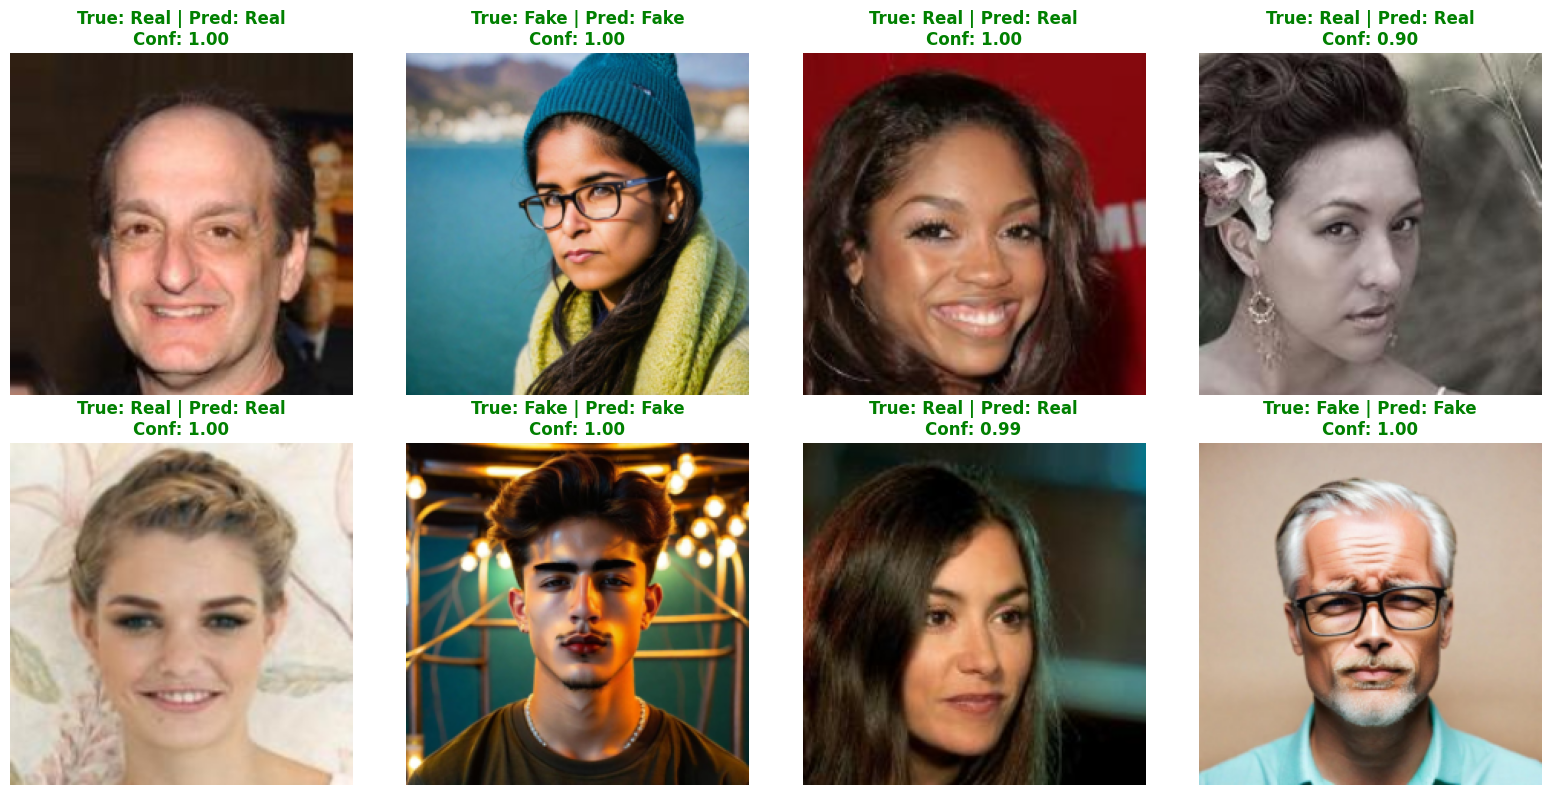

In [17]:
# Lấy một batch từ test set để visualize
model.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)

# Predict
with torch.no_grad():
    outputs = model(images)
    predictions = (outputs > 0.5).float()

# Denormalize để hiển thị
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1).to(device)
std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1).to(device)
images_denorm = images * std + mean
images_denorm = torch.clamp(images_denorm, 0, 1)

# Plot up to 8 images in the batch
max_show = min(len(images_denorm), 8)
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for idx in range(max_show):
    ax = axes[idx]
    img = images_denorm[idx].cpu().permute(1, 2, 0).numpy()
    ax.imshow(img)
    
    true_label = "Real" if labels[idx].item() == 0 else "Fake"
    pred_label = "Real" if predictions[idx].item() == 0 else "Fake"
    confidence = outputs[idx].item() if predictions[idx].item() == 1 else 1 - outputs[idx].item()
    
    color = 'green' if predictions[idx] == labels[idx] else 'red'
    ax.set_title(f"True: {true_label} | Pred: {pred_label}\nConf: {confidence:.2f}", 
                 color=color, fontweight='bold')
    ax.axis('off')

# Hide unused axes if batch smaller than grid
for j in range(max_show, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 10. Plot Training History

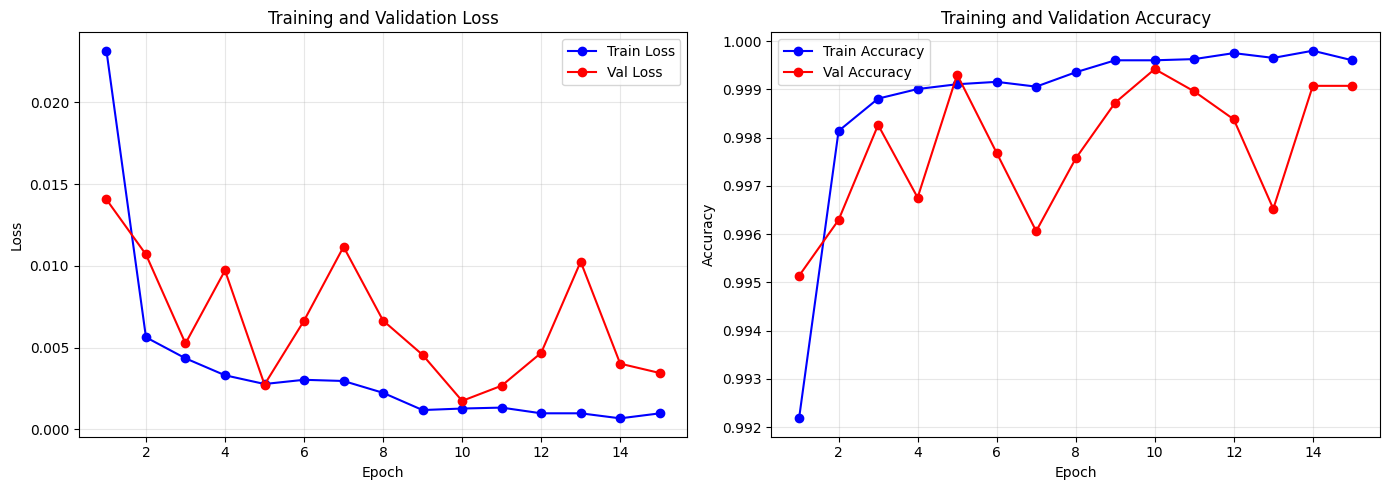


Best validation accuracy: 0.9994
Final test accuracy: 0.9991


In [18]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
epochs = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy')
ax2.plot(epochs, history['val_acc'], 'r-o', label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest validation accuracy: {max(history['val_acc']):.4f}")
print(f"Final test accuracy: {test_acc:.4f}")

## Lưu Model và Metadata

In [19]:
# Lưu model cuối cùng với metadata đầy đủ
final_model_path = MODEL_SAVE_PATH / "final_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'img_size': IMG_SIZE,
    },
    'model_config': {
        'backbone': 'CLIP-ViT-L/14',
        'frozen_backbone': True,
        'head_layers': [768, 512, 128, 1],
    }
}, final_model_path)

print(f"✓ Saved final model to {final_model_path}")
print(f"✓ Best model saved at {best_model_path}")
print("\nTraining complete! Models and weights saved successfully.")

✓ Saved final model to /kaggle/working/final_model.pth
✓ Best model saved at /kaggle/working/best_model.pth

Training complete! Models and weights saved successfully.


## Model có thể tải về từ gg drive: https://drive.google.com/file/d/18hHMNL1HPnpgDLXmSM55rVJFP_On7i_H/view?usp=sharing